# New York Taxi Fare Prediction :

<u>Course project for "Probability and Statistics"</u>

**Name** - Ashutosh Sathe

**Class** - T.Y.B.Tech Computer Engineering

### Setting up Google Colab:
In order to download datasets from kaggle, we need to setup kaggle API key and upload it to Google colab session to allow it to use it.

In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

In [0]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 51.3MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 61.7MB/s]
 99% 1.55G/1.56G [00:16<00:00, 100MB/s]
100% 1.56G/1.56G [00:16<00:00, 101MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 485kB/s]


In [0]:
!ls
!unzip train.csv.zip
!ls

GCP-Coupons-Instructions.rtf  sample_data	     test.csv
kaggle.json		      sample_submission.csv  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               
GCP-Coupons-Instructions.rtf  sample_data	     test.csv	train.csv.zip
kaggle.json		      sample_submission.csv  train.csv


### Approach :
Since here we want to try end-to-end deep learning, I'll focus minimum on preparation of data. I'll just take care of mostly erraneous stuff such as negative fare, trips to water etc.

In [0]:
# based right off the data exploration kernel on kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [0]:
df_train = pd.read_csv('train.csv', nrows = 5_000_000, \
                      parse_dates=['pickup_datetime'])
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# Removing negative fare amount datapoints
print('Size before removing any negative fare datapoints: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('Size after removing all negative fare datapoints: %d' % len(df_train))

Size before removing any negative fare datapoints: 5000000
Size after removing all negative fare datapoints: 4999789


In [0]:
# Removing null datapoints
print("The null datapoints are :")
print(df_train.isnull().sum())
print('Size before removing any null valued datapoints: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('Size after removing all null valued datapoints: %d' % len(df_train))

The null datapoints are :
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64
Size before removing any null valued datapoints: 4999789
Size after removing all null valued datapoints: 4999753


In [0]:
# Removing all the datapoints outside the bounding box
BB = (-74.5, -72.8, 40.5, 41.0)

def select_within_boundingbox(df, BB):
  return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
         (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
         (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
         (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

print('Size before removing datapoints outside boundary box: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('Size after removing datapoints outside boundary box: %d' % len(df_train))

Size before removing datapoints outside boundary box: 4999753
Size after removing datapoints outside boundary box: 4891109


In [0]:
# Removing the datapoints in the water
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')
  
pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)


idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))
print("Size before removing any water trips: %d" % len(df_train))
df_train = df_train[idx]
print("Size after removing all water trips: %d" % len(df_train))

Number of trips in water: 70118
Size before removing any water trips: 4891109
Size after removing all water trips: 4820991


In [0]:
# We need some distances for getting a basic model
# Obviously using the formula from stack overflow
nyc = (-74.0063889, 40.7141667) # NYC center
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * \
        np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
  
df_train['pickup_distance_to_center'] = distance(nyc[1], nyc[0], df_train.pickup_latitude, \
                                          df_train.pickup_longitude)
df_train['travel_distance_miles'] = distance(df_train.pickup_latitude, \
                                             df_train.pickup_longitude, \
                                             df_train.dropoff_latitude, \
                                             df_train.dropoff_longitude, \
                                            )


In [0]:
# Introducing a sense of direction
#      B
#     /|
#    / |<delta_lon>
#   /  |
# A/___|
# <delta_lat>
df_train['delta_lat'] = df_train.pickup_latitude - df_train.dropoff_latitude
df_train['delta_lon'] = df_train.pickup_longitude - df_train.dropoff_longitude

In [0]:
# add time info
df_train['year'] = df_train.pickup_datetime.apply(lambda t: t.year)
df_train['weekday'] = df_train.pickup_datetime.apply(lambda t: t.weekday())
df_train['hour'] = df_train.pickup_datetime.apply(lambda t: t.hour)

In [0]:
# Checking all the features and datatypes before training
df_train.dtypes

key                                  object
fare_amount                         float64
pickup_datetime              datetime64[ns]
pickup_longitude                    float64
pickup_latitude                     float64
dropoff_longitude                   float64
dropoff_latitude                    float64
passenger_count                       int64
pickup_distance_to_center           float64
travel_distance_miles               float64
delta_lat                           float64
delta_lon                           float64
year                                  int64
weekday                               int64
hour                                  int64
dtype: object

### Building up model
Built a simple model to demonstrate working of deep learning.

In [0]:
# Start building the model
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
print("Tensorflow version: %s" % tf.__version__)
def build_model():
  model = keras.Sequential([
      keras.layers.Dense(64, activation=tf.nn.relu, 
                         input_shape=(7,)),
      keras.layers.Dense(128, activation=tf.nn.relu),
      keras.layers.Dense(256, activation=tf.nn.relu),
      keras.layers.Dense(128, activation=tf.nn.relu),
      keras.layers.Dense(64, activation=tf.nn.relu),
      keras.layers.Dense(1)
  ])
  
  optimizer = tf.train.RMSPropOptimizer(0.001)
  
  model.compile(loss='mse',
               optimizer=optimizer,
               metrics=['mae'])
  return model

training_model = build_model()
training_model.summary()

Tensorflow version: 1.13.0-rc1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65

In [0]:
# Remove points with 0 passengers
idx = df_train.passenger_count != 0
# Choosing the basic model
# fare <-- (year, weekday, hour, travel_distance_miles, passenger_count,\
#           delta_lat, delta_lon)
features = ['year', 'weekday', 'hour', 'travel_distance_miles', 'passenger_count',
            'delta_lat', 'delta_lon']
X = df_train[idx][features].values
y = df_train[idx]['fare_amount'].values
# Training the actual model
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')
    
EPOCHS=5

# Store training stats
history = training_model.fit(X, y, epochs=EPOCHS, validation_split=0.2, verbose=2,
                    callbacks=[PrintDot()])

Train on 3843224 samples, validate on 960806 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5

. - 379s - loss: 28.3409 - mean_absolute_error: 2.7409 - val_loss: 22.9949 - val_mean_absolute_error: 2.4002
Epoch 2/5
. - 377s - loss: 23.3796 - mean_absolute_error: 2.4832 - val_loss: 23.3310 - val_mean_absolute_error: 2.3711
Epoch 3/5
. - 373s - loss: 23.0008 - mean_absolute_error: 2.4462 - val_loss: 22.2828 - val_mean_absolute_error: 2.3188
Epoch 4/5
. - 373s - loss: 22.8278 - mean_absolute_error: 2.4321 - val_loss: 22.0989 - val_mean_absolute_error: 2.3474
Epoch 5/5
. - 370s - loss: 22.7468 - mean_absolute_error: 2.4159 - val_loss: 22.5550 - val_mean_absolute_error: 2.4142


In [0]:
# Save the preprocessed dataframe into google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive"
df_train.to_csv("training_preproc_5m.csv", sep='\t', encoding='utf-8')
!cp "training_preproc_5m.csv" "/content/drive/My Drive/NewYorkTaxiFare"
!ls "/content/drive/My Drive/NewYorkTaxiFare"

'Colab Notebooks'   NewYorkTaxiFare
training_preproc_5m.csv


In [0]:
# Also save the model to google drive
!pip install -q h5py pyyaml 
training_model.save("training_model.h5")
!cp "training_model.h5" "/content/drive/My Drive/"

In [0]:
df_test = pd.read_csv("test.csv", parse_dates=['pickup_datetime'])

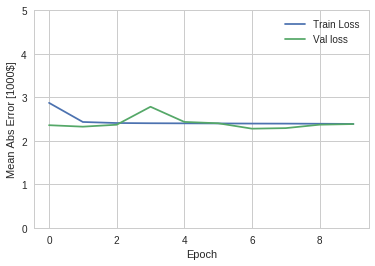

In [0]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

In [0]:
df_test['pickup_distance_to_center'] = distance(nyc[1], nyc[0], df_test.pickup_latitude, \
                                          df_test.pickup_longitude)
df_test['travel_distance_miles'] = distance(df_test.pickup_latitude, \
                                             df_test.pickup_longitude, \
                                             df_test.dropoff_latitude, \
                                             df_test.dropoff_longitude, \
                                            )
df_test['delta_lat'] = df_test.pickup_latitude - df_test.dropoff_latitude
df_test['delta_lon'] = df_test.pickup_longitude - df_test.dropoff_longitude

df_test['year'] = df_test.pickup_datetime.apply(lambda t: t.year)
df_test['weekday'] = df_test.pickup_datetime.apply(lambda t: t.weekday())
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: t.hour)
test_idx = df_test.passenger_count != 0
# Choosing the basic model
# fare <-- (year, weekday, hour, travel_distance_miles, passenger_count,\
#           delta_lat, delta_lon)
features = ['year', 'weekday', 'hour', 'travel_distance_miles', 'passenger_count',
            'delta_lat', 'delta_lon']
test_X = df_test[test_idx][features].values
test_y = training_model.predict(test_X).flatten()
print(test_y)

[ 9.780495   9.805965   4.670234  ... 52.88061   21.628372   7.0981464]


In [0]:
submission = open("submission.csv", "w")
submission.write("key,fare_amount\n")
for i in range(0, len(test_y)):
  submission.write(df_test['key'][i] + ',' + str(test_y[i]) + '\n')
  
submission.close()
!cp "submission.csv" "/content/drive/My Drive/NewYorkTaxiFare/"

In [0]:
# A refresh of the session
from google.colab import drive
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
% matplotlib inline
plt.style.use('seaborn-whitegrid')

print("Tensorflow version: %s" % tf.__version__)
drive.mount("/content/drive")
print("Loading training files")

!cp "/content/drive/My Drive/NewYorkTaxiFare/training_model.h5" "./"
!cp "/content/drive/My Drive/NewYorkTaxiFare/checkpoint_weights.hdf5" "./"
!cp "/content/drive/My Drive/NewYorkTaxiFare/training_preproc_5m.csv" "./"
!cp "/content/drive/My Drive/NewYorkTaxiFare/test.csv" "./"

!ls -al
# We do want logs tensorflow sessions
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
df_train_loaded = pd.read_csv("training_preproc_5m.csv", encoding='utf-8', sep='\t') 
df_train_loaded.head()
restored_model = keras.models.load_model("training_model.h5")
restored_model = keras.models.load_model("checkpoint_weights.hdf5")
# optimizer = tf.train.RMSPropOptimizer(0.001) Not using the tensorflow optmiizer this time
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
restored_model.compile(loss='mse',
                       optimizer=optimizer,
                       metrics=['mae'])
# Remove points with 0 passengers
idx = (df_train_loaded.passenger_count != 0) & (df_train_loaded.travel_distance_miles > 0.00)
# Choosing the basic model
# fare <-- (year, weekday, hour, travel_distance_miles, passenger_count,\
#           delta_lat, delta_lon)
features = ['year', 'weekday', 'hour', 'travel_distance_miles', 'passenger_count',
            'delta_lat', 'delta_lon']
X = df_train_loaded[idx][features].values
y = df_train_loaded[idx]['fare_amount'].values
# Training the actual model
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')
    
EPOCHS=30

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/NewYorkTaxiFare/checkpoint_weights.hdf5', verbose=1, save_best_only=True)
# Store training stats
history = restored_model.fit(X, y, epochs=EPOCHS, validation_split=0.2, verbose=2,
                    callbacks=[PrintDot(), checkpointer])

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)


nyc = (-74.0063889, 40.7141667) # NYC center

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * \
        np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

# Get the test data and preprocess it
df_test = pd.read_csv("test.csv", parse_dates=['pickup_datetime'])
df_test['pickup_distance_to_center'] = distance(nyc[1], nyc[0], df_test.pickup_latitude, \
                                          df_test.pickup_longitude)
df_test['travel_distance_miles'] = distance(df_test.pickup_latitude, \
                                             df_test.pickup_longitude, \
                                             df_test.dropoff_latitude, \
                                             df_test.dropoff_longitude, \
                                            )
df_test['delta_lat'] = df_test.pickup_latitude - df_test.dropoff_latitude
df_test['delta_lon'] = df_test.pickup_longitude - df_test.dropoff_longitude

df_test['year'] = df_test.pickup_datetime.apply(lambda t: t.year)
df_test['weekday'] = df_test.pickup_datetime.apply(lambda t: t.weekday())
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: t.hour)
test_idx = df_test.passenger_count != 0
# Choosing the basic model
# fare <-- (year, weekday, hour, travel_distance_miles, passenger_count,\
#           delta_lat, delta_lon)
features = ['year', 'weekday', 'hour', 'travel_distance_miles', 'passenger_count',
            'delta_lat', 'delta_lon']
test_X = df_test[test_idx][features].values
test_y = restored_model.predict(test_X).flatten()
print("Average taxi fare after training: " + str((sum(test_y) / len(test_y))))

# Write the submission file 
submission = open("submission.csv", "w")
submission.write("key,fare_amount\n")
for i in range(0, len(test_y)):
  submission.write(df_test['key'][i] + ',' + str(test_y[i]) + '\n')
  
submission.close()
!cp "submission.csv" "/content/drive/My Drive/NewYorkTaxiFare/"

Using TensorFlow backend.


Tensorflow version: 1.12.0-rc1
Mounted at /content/drive
Loading training files
total 951256
drwxr-xr-x 1 root root      4096 Oct 30 09:32 .
drwxr-xr-x 1 root root      4096 Oct 30 09:27 ..
-rw------- 1 root root     93176 Oct 30 09:31 checkpoint_weights.hdf5
drwxr-xr-x 4 root root      4096 Oct 26 16:29 .config
drwx------ 3 root root      4096 Oct 30 09:31 drive
drwxr-xr-x 2 root root      4096 Oct 26 16:42 sample_data
-rw------- 1 root root    983020 Oct 30 09:32 test.csv
-rw------- 1 root root     93176 Oct 30 09:31 training_model.h5
-rw------- 1 root root 972887081 Oct 30 09:32 training_preproc_5m.csv
Train on 3803367 samples, validate on 950842 samples
Epoch 1/30

.
Epoch 00001: val_loss improved from inf to 21.33033, saving model to /content/drive/My Drive/NewYorkTaxiFare/checkpoint_weights.hdf5
 - 139s - loss: 20.1361 - mean_absolute_error: 2.2978 - val_loss: 21.3303 - val_mean_absolute_error: 2.5962
Epoch 2/30
.
Epoch 00002: val_loss improved from 21.33033 to 20.39027, saving m

In [0]:
nyc = (-74.0063889, 40.7141667) # NYC center

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * \
        np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
  
df_test = pd.read_csv("test.csv", parse_dates=['pickup_datetime'])
df_test['pickup_distance_to_center'] = distance(nyc[1], nyc[0], df_test.pickup_latitude, \
                                          df_test.pickup_longitude)
df_test['travel_distance_miles'] = distance(df_test.pickup_latitude, \
                                             df_test.pickup_longitude, \
                                             df_test.dropoff_latitude, \
                                             df_test.dropoff_longitude, \
                                            )
df_test['delta_lat'] = df_test.pickup_latitude - df_test.dropoff_latitude
df_test['delta_lon'] = df_test.pickup_longitude - df_test.dropoff_longitude

df_test['year'] = df_test.pickup_datetime.apply(lambda t: t.year)
df_test['weekday'] = df_test.pickup_datetime.apply(lambda t: t.weekday())
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: t.hour)
test_idx = df_test.passenger_count != 0
# Choosing the basic model
# fare <-- (year, weekday, hour, travel_distance_miles, passenger_count,\
#           delta_lat, delta_lon)
features = ['year', 'weekday', 'hour', 'travel_distance_miles', 'passenger_count',
            'delta_lat', 'delta_lon']
test_X = df_test[test_idx][features].values
test_y = restored_model.predict(test_X).flatten()
print("Average taxi fare after training: " + str((sum(test_y) / len(test_y))))

# Write the submission file 
submission = open("submission.csv", "w")
submission.write("key,fare_amount\n")
for i in range(0, len(test_y)):
  submission.write(df_test['key'][i] + ',' + str(test_y[i]) + '\n')
  
submission.close()
!cp "submission.csv" "/content/drive/My Drive/NewYorkTaxiFare/"

Average taxi fare after training: 10.060709018006978


In [0]:
restored_model.save("training_model.h5")
!cp "training_model.h5" "/content/drive/My Drive/NewYorkTaxiFare/"